In [133]:
from numpy.random import randint, random, choice
from netaddr import IPAddress, IPNetwork
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt

from pprint import pprint as pp
import numpy as np
%matplotlib inline  

In [134]:
MAX_IP_INT = 4200000000
nmin, nmax, dn = 100000, 1000001, 100000
allN = range(nmin, nmax, dn)
num_of_excludes = range(0,50, 5)

In [135]:

no_exclude_dts = []
for N in allN:
    t0 = datetime.now()
    for n in range(N):
        IPAddress(randint(0, MAX_IP_INT))
    no_exclude_dts.append((datetime.now() - t0).total_seconds())

In [136]:
print('Rate of {:.2f} ips/second'.format(allN[-1]/no_exclude_dts[-1]))

Rate of 220059.67 ips/second


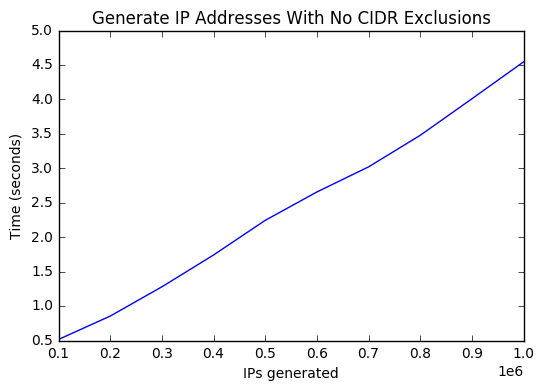

In [137]:
fig = plt.figure()
plt.plot(allN, no_exclude_dts)
plt.xlabel('IPs generated')
plt.ylabel('Time (seconds)')
plt.title('Generate IP Addresses With No CIDR Exclusions')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [138]:
single_exclude = [ IPNetwork('192.168.0.0/16')]

In [139]:
single_exclude_dts = []
for N in allN:
    t0 = datetime.now()
    for n in range(N):
        rnd = randint(0, MAX_IP_INT)
        while any([rnd in e for e in single_exclude]):
            rnd = randint(0, MAX_IP_INT)
        IPAddress(rnd)
    single_exclude_dts.append((datetime.now() - t0).total_seconds())

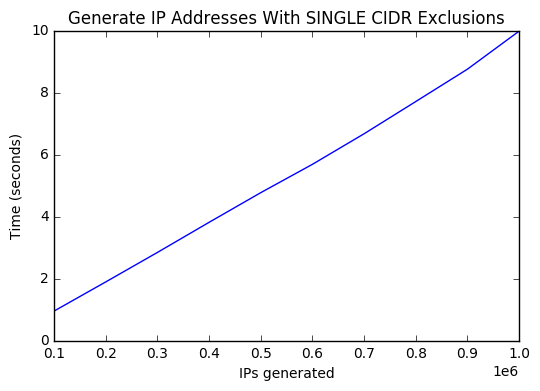

In [140]:
fig = plt.figure()
plt.plot(allN, single_exclude_dts)
plt.xlabel('IPs generated')
plt.ylabel('Time (seconds)')
plt.title('Generate IP Addresses With SINGLE CIDR Exclusions')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [141]:
print('Rate of {:.2f} ips/second'.format(allN[-1]/single_exclude_dts[-1]))

Rate of 100201.69 ips/second


In [142]:
def build_exclude(n):
    starts = [ randint(0, MAX_IP_INT) for i in range(n)]
    excludes = []
    widths = range(16,32)
    for s in starts:
        e = IPNetwork('0.0.0.0')
        e.value = s
        e.prefixlen = int(choice(widths))
        excludes.append(e)
    return excludes

In [143]:
multiple_exclude_dts = []
N = allN[-1]
for NE in num_of_excludes:
    multiple_excludes = build_exclude(NE)
    t0 = datetime.now()
    for n in range(N):
        rnd = randint(0, MAX_IP_INT)
        while any([rnd in e for e in multiple_excludes]):
            rnd = randint(0, MAX_IP_INT)
        IPAddress(rnd)
    multiple_exclude_dts.append((datetime.now() - t0).total_seconds())

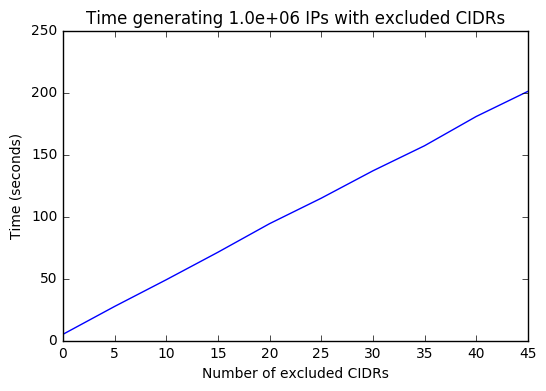

In [144]:
fig = plt.figure()
plt.plot(num_of_excludes, multiple_exclude_dts)
plt.xlabel('Number of excluded CIDRs')
plt.ylabel('Time (seconds)')
plt.title('Time generating {:.1e} IPs with excluded CIDRs'.format(allN[-1]))

In [145]:
print('Rate of {:.2f} ips/second'.format(allN[-1]/multiple_exclude_dts[-1]))

Rate of 4977.30 ips/second


In [146]:


MAX_VAL = 255**4

class IPGenerator:

    def set_excludes(self, excludes):
        self._excludes = sorted(excludes)
        self._build_valid_blocks()

    def __get_start_end(self, block):
        return block[0].value,block[-1].value


    def _build_valid_blocks(self):
        ex_start_stop = [ self.__get_start_end(e) for e in self._excludes ]
        valid = [[0,0,0]]
        i = 0
        while i< len(ex_start_stop):
            s,e = ex_start_stop[i]
            # print(i,s,e)
            if i+1 < len(ex_start_stop):
                ns,ne = ex_start_stop[i+1]
                if ns <= e:
                    # If the next end is greater than the curren end, just use next
                    # end as the current. This will create a new superblock
                    if ne >e:
                        e = ne
                    # Either we've created a new super block, or the next block is
                    # contained within this current block. In either case we can
                    # safely remove the next block
                    del ex_start_stop[i+1]
            valid[-1][1] = s
            valid[-1][2] = s - valid[-1][0]
            if valid[-1][2] == 0:
                del valid[-1]
            valid.append([e+1,0,0])
            i += 1

        # Final block should end with the max value allowed.
        valid[-1][1] = MAX_VAL
        valid[-1][2] = MAX_VAL - valid[-1][0]

        # Normalize the weights
        total = sum([e[-1] for e in valid])
        for i in range(len(valid)):
            valid[i].append(valid[i][-1]/total)

        self.valid_ranges = valid

    def __assert_valid(self, guess):
        return any([guess >=s and guess<e for s,e,l,w in self.valid_ranges])

    def check_valid_ips(self, ips):
        return [ ip for ip in ips if any([ip.value >=s and ip.value<e for s,e,l,w in self.valid_ranges]) ]
        

    def random_number_test(self, N=100000):
        for i in range(N):
            assert self.__assert_valid(valid, generate_random_value())

    def generate_random_value(self):
        rnd = random()
        for s,e,l,w in self.valid_ranges:
            if rnd<w:
                return randint(s,e)
            rnd -= w
        print(rnd)
        raise ValueError

    def generate_ip(self):
        return IPAddress(self.generate_random_value())

    def benchmark_speed(self, N=100000):
        d0 = datetime.now()
        for i in range(N):
            assert self.__assert_valid(self.generate_random_value())
        dt = (datetime.now() - d0).total_seconds()
        print('Performing generate at a rate of {:.2f}/second'.format(N/dt))


In [153]:

new_multiple_exclude_dts = []
pre_processing_dts = []
N = allN[2]

ipgen = IPGenerator()

for NE in num_of_excludes:
    t0 = datetime.now()
    multiple_excludes = build_exclude(NE)
    ipgen.set_excludes(multiple_excludes)
    pre_processing_dts.append((datetime.now() - t0).total_seconds())
    t0 = datetime.now()
    for n in range(N):        
        IPAddress(ipgen.generate_random_value())
    new_multiple_exclude_dts.append((datetime.now() - t0).total_seconds())

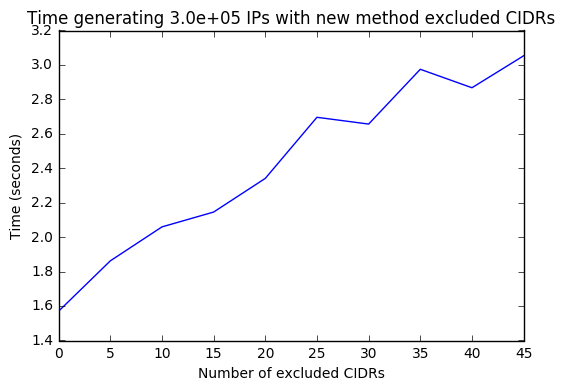

In [148]:
fig = plt.figure()
line1 = plt.plot(num_of_excludes, new_multiple_exclude_dts, label='Generate IPs')
plt.xlabel('Number of excluded CIDRs')
plt.ylabel('Time (seconds)')
plt.title('Time generating {:.1e} IPs with new method excluded CIDRs'.format(N))

In [152]:
print('Preprocessing took {:.2e} seconds'.format(pre_processing_dts[-1]))
print('Generating Rate of {:.2f} ips/second'.format(N/new_multiple_exclude_dts[-1]))

Preprocessing took 2.66e-03 seconds
Generating Rate of 98260.43 ips/second
